# Linear Regression Model of Housing Value

I want to relate housing prices to the natural amenities found in a given county. I will be using a dataset called the Natural Amenities Scale, which can be found [here](https://www.ers.usda.gov/data-products/natural-amenities-scale.aspx)

I will also be using a dataset of 

In [628]:
import pandas as pd
import numpy as np

In [629]:
# importing natural amenity csv
nat = pd.read_csv('/Users/patricknorman/Documents/GitHub/metis-project-2/data/nat_amen_clean.csv')

In [630]:
# verifying sucessful import
nat.head()

,FIPS,COMBINED_COUNTY_INDEX,STATE,COUNTY,CENSUS_DIV,RUC,UIC,JAN_TEMP,JAN_SUN,JULY_TEMP,...,WATER,LN_WATER,JAN TEMP - Z,JAN SUN - Z,JUL TEMP - Z,JUL HUM - Z,TOPOG - Z,LN WATER AREA - Z,NAT_AMENITY,RANK
0,1001,1001,AL,AUTAUGA,6,2,2,47.4,130,81.0,...,1.40,4.944,1.20277,-0.64758,-0.13206,-0.68502,0.77701,0.26585,0.78,4
1,1003,1003,AL,BALDWIN,6,2,2,51.9,152,80.6,...,21.24,7.661,1.57504,0.01482,0.36308,-1.09576,-0.73966,1.70428,1.82,4
2,1005,1005,AL,BARBOUR,6,6,5,48.8,152,81.0,...,2.17,5.378,1.31859,0.01482,-0.01148,-0.89039,-0.73966,0.49570,0.19,4
3,1007,1007,AL,BIBB,6,6,6,44.8,130,80.8,...,0.50,3.916,0.98768,-0.64758,-0.30223,-0.68502,0.77701,-0.27812,-0.15,3
4,1009,1009,AL,BLOUNT,6,2,2,41.9,130,78.4,...,0.76,4.336,0.74778,-0.64758,0.09330,-0.68502,0.77701,-0.05592,0.23,4


In [631]:
#clarifying some column names
nat.rename(columns={'RUC':'RUC_93','UIC':'UIC_93'},inplace=True)

In [632]:
# examining shape
nat.shape

(3111, 22)

# Housing Data
I've found a good housing cost dataset for 2013 [here](https://data.census.gov/cedsci/table?q=home%20values%202013%20county&t=Housing&g=0100000US.050000&tid=ACSST1Y2013.S2506&hidePreview=true). I just have to import it and wrangle with the insane format.

Note: Don't be alarmed, this is just a list of 495 counties. It's supposedly a representative sample according to the Census...

In [633]:
# importing housing df
housing_raw = pd.read_csv('/Users/patricknorman/Documents/GitHub/metis-project-2/data/2013_housing.csv')
#housing_raw

In [634]:
# formatting housing df
housing = housing_raw.transpose()
housing.columns = housing.iloc[0]
housing.drop(labels=['Label'],inplace=True)
housing.reset_index(inplace=True)
housing.rename(columns={
    'index':'COUNTY',
    'Owner-occupied housing units with a mortgage':'N'},
               inplace=True)

housing.COUNTY = housing.COUNTY.replace({'!!Owner-occupied housing units with a mortgage!!':' ',
                                        'Estimate':'EST','Margin of Error':'MAR',
                                        'County,':'',
                                        ',':''}, regex=True,)

state_abb = {'Alabama':'AL','Alaska': 'AK','Arizona':'AZ','Arkansas':'AR',
             'California':'CA','Colorado':'CO','Conneticut':'CT','Delaware':'DE',
             'Florida':'FL','Georgia':'GA','Hawaii':'HI','Idaho':'ID','Illinois':'IL',
             'Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA',
             'Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
             'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE',
             'Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM',
             'New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH',
             'Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI',
             'South Carolina':'SC','South Dakota':'SD','Tennessee':'TN','Texas':'TX',
             'Utah':'UT','Vermont':'VT','West Virginia':'WV','Virginia':'VA','Washington':'WA',
             'Wisconsin':'WI','Wyoming':'WY'}

housing.COUNTY = housing.COUNTY.replace(state_abb,regex=True)

In [635]:
# creating column for STATE
housing['STATE'] = housing.COUNTY.apply(lambda x: str(x)[-6:-3])

housing['STATE'] = housing['STATE'].str.upper()
#housing.head()

In [636]:
housing.columns

Index(['COUNTY', 'N', 'VALUE', 'Less than $50,000', '$50,000 to $99,999',
       '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $299,999',
       '$300,000 to $499,999', '$500,000 or more', 'MEDIAN_VAL',
       'MORTGAGE STATUS',
       '    With either a second mortgage, or home equity loan, but not both',
       '        Second mortgage only', '        Home equity loan only',
       '    Both second mortgage and home equity loan',
       '    No second mortgage and no home equity loan',
       'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2013 INFLATION-ADJUSTED DOLLARS)',
       'Less than $10,000', '$10,000 to $24,999', '$25,000 to $34,999',
       '$35,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999',
       '$100,000 to $149,999', '$150,000 or more',
       '    Median household income (dollars)',
       'RATIO OF VALUE TO HOUSEHOLD INCOME IN THE PAST 12 MONTHS',
       'Less than 2.0', '2.0 to 2.9', '3.0 to 3.9', '4.0 or more',
       '    Not computed', '

In [637]:
# before I continue, let's get rid of some of the columns that i dont need
house = housing[['COUNTY','N','STATE','MEDIAN_VAL']] 
house.tail()

Label,COUNTY,N,STATE,MEDIAN_VAL
994,Rutherford NC EST,"8,552",NC,"115,200"
995,Rutherford NC MAR,"±1,169",NC,"±19,775"
996,Pasco FL EST,"72,592",FL,"143,600"
997,Pasco FL MAR,"±2,756",FL,"±7,379"
998,Jasper MO EST,"17,315",MO,"118,300"


In [638]:
house.shape

(999, 4)

(array([102., 105.,  97., 109., 104., 103.,  97.,  94.,  94.,  94.]),
 array([  0. ,  93.1, 186.2, 279.3, 372.4, 465.5, 558.6, 651.7, 744.8,
        837.9, 931. ]),
 <BarContainer object of 10 artists>)

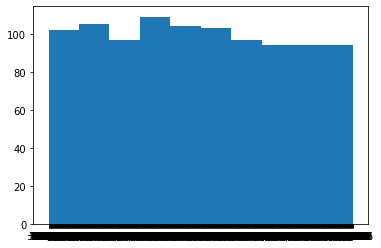

In [639]:
plt.hist(house['MEDIAN_VAL'])

#plt.savefig('housing_hist.png')

In [640]:
len(house)

999

In [641]:
house.MEDIAN_VAL.values

array(['224,000', '±20,267', '145,900', '±42,512', '173,600', '±14,461',
       '132,900', '±16,065', '144,900', '±10,321', '187,400', '±12,999',
       '158,100', '±9,955', '176,000', '±21,072', '339,000', '±22,432',
       '261,400', '±11,629', '120,200', '±13,445', '223,300', '±13,861',
       '141,100', '±25,252', '105,300', '±41,798', '131,800', '±26,407',
       '441,000', '±5,160', '363,800', '±14,380', '416,200', '±11,778',
       '508,900', '±17,324', '164,700', '±6,646', '226,500', '±22,861',
       '348,900', '±37,854', '129,700', '±14,525', '102,700', '±15,010',
       '99,100', '±12,071', '103,600', '±33,704', '153,900', '±21,977',
       '172,600', '±9,543', '100,000', '±12,514', '119,400', '±8,725',
       '133,200', '±20,666', '598,500', '±25,988', '354,300', '±21,900',
       '297,600', '±23,887', '213,900', '±26,052', '304,800', '±20,805',
       '463,800', '±32,176', '168,000', '±6,668', '130,200', '±19,777',
       '141,800', '±16,153', '117,000', '±6,518', '146,000

In [642]:
# lets also strip whitespace from STATE for good measure
house['STATE'] = house['STATE'].apply(lambda x: str(x).strip())

<ipython-input-642-575fea2df78f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house['STATE'] = house['STATE'].apply(lambda x: str(x).strip())


In [643]:
# removing margins of error from house
house = house[~house.COUNTY.str.contains('MAR')]

# removing alaska and hawaii
house = house[~house.COUNTY.str.contains('AK')]
house = house[~house.COUNTY.str.contains('HI')]

house.head()

# removing state and est from COUNTY, uppercasing
house.COUNTY = house.COUNTY.apply(lambda x: str(x)[:-7].upper())

# stripping whitespace from COUNTY
house['COUNTY'] = house['COUNTY'].str.strip()

# Investigating Missing States

In [644]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

states = ["", "", "", "", "", "", "CT", "", "", "", 
          "", "", "", "", "", "", "", "", "", "", 
          "", "", "", "", "", "", "", "", "", "", 
          "", "", "", "", "", "", "", "", "", "", 
          "", "", "", "", "VT", "", "", "WV", "", ""]

In [645]:
# hmm, seem to be only 48 states made it into the df... is that accurate???
len(house['STATE'].unique())

46

In [646]:
# first let's identify which states aren't included.
house['STATE'].unique()

array(['AZ', 'CA', 'GA', 'IL', 'IN', 'KS', 'MD', 'MS', 'NH', 'NM', 'NY',
       'ND', 'RI', 'TX', 'VA', 'WA', 'CO', 'OH', 'MO', 'FL', 'IA', 'AL',
       'LA', 'WV', 'OR', 'MI', 'SC', 'TN', 'KY', 'UT', 'PA', 'MN', 'NC',
       'AR', 'MT', 'NJ', 'WY', 'MA', 'WI', 'OK', 'ID', 'NV', 'SD', 'NE',
       'DE', 'ME'], dtype=object)

we seem to be missing entries for CT, VT, and WV. Let's verify that these exist

there seems to be no entries for VT. What? Oh well. There are for WV and CT. Where did they go when we created STATE column?

# Updating RUCC
It's been difficult to find housing data for 1993, so I think I might just update the urban-rural continuum codes so that I can use housing prices that are more recent. I have 2013 codes [here](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx)

In [647]:
# importing RUC_2013
ruc_13 = pd.read_csv('/Users/patricknorman/Documents/GitHub/metis-project-2/data/ruc_13/ruc_2013.csv')
ruc_13.head()

,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,1001,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,1003,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...
2,1005,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
3,1007,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...
4,1009,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...


In [648]:
nat.head()

,FIPS,COMBINED_COUNTY_INDEX,STATE,COUNTY,CENSUS_DIV,RUC_93,UIC_93,JAN_TEMP,JAN_SUN,JULY_TEMP,...,WATER,LN_WATER,JAN TEMP - Z,JAN SUN - Z,JUL TEMP - Z,JUL HUM - Z,TOPOG - Z,LN WATER AREA - Z,NAT_AMENITY,RANK
0,1001,1001,AL,AUTAUGA,6,2,2,47.4,130,81.0,...,1.40,4.944,1.20277,-0.64758,-0.13206,-0.68502,0.77701,0.26585,0.78,4
1,1003,1003,AL,BALDWIN,6,2,2,51.9,152,80.6,...,21.24,7.661,1.57504,0.01482,0.36308,-1.09576,-0.73966,1.70428,1.82,4
2,1005,1005,AL,BARBOUR,6,6,5,48.8,152,81.0,...,2.17,5.378,1.31859,0.01482,-0.01148,-0.89039,-0.73966,0.49570,0.19,4
3,1007,1007,AL,BIBB,6,6,6,44.8,130,80.8,...,0.50,3.916,0.98768,-0.64758,-0.30223,-0.68502,0.77701,-0.27812,-0.15,3
4,1009,1009,AL,BLOUNT,6,2,2,41.9,130,78.4,...,0.76,4.336,0.74778,-0.64758,0.09330,-0.68502,0.77701,-0.05592,0.23,4


In [649]:
# merging 2013 urban metric into nat
nat_13 = pd.merge(nat,ruc_13['RUCC_2013'],
                      left_on=nat['FIPS'],
                      right_on=ruc_13['FIPS'])

nat_13.drop('key_0',axis=1, inplace=True)
nat_13.drop('RUC_93',axis=1, inplace=True)
nat_13.drop('UIC_93',axis=1, inplace=True)

nat_13.head()

,FIPS,COMBINED_COUNTY_INDEX,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,TOPO,...,LN_WATER,JAN TEMP - Z,JAN SUN - Z,JUL TEMP - Z,JUL HUM - Z,TOPOG - Z,LN WATER AREA - Z,NAT_AMENITY,RANK,RUCC_2013
0,1001,1001,AL,AUTAUGA,6,47.4,130,81.0,66,14,...,4.944,1.20277,-0.64758,-0.13206,-0.68502,0.77701,0.26585,0.78,4,2.0
1,1003,1003,AL,BALDWIN,6,51.9,152,80.6,72,4,...,7.661,1.57504,0.01482,0.36308,-1.09576,-0.73966,1.70428,1.82,4,3.0
2,1005,1005,AL,BARBOUR,6,48.8,152,81.0,69,4,...,5.378,1.31859,0.01482,-0.01148,-0.89039,-0.73966,0.49570,0.19,4,6.0
3,1007,1007,AL,BIBB,6,44.8,130,80.8,66,14,...,3.916,0.98768,-0.64758,-0.30223,-0.68502,0.77701,-0.27812,-0.15,3,1.0
4,1009,1009,AL,BLOUNT,6,41.9,130,78.4,66,14,...,4.336,0.74778,-0.64758,0.09330,-0.68502,0.77701,-0.05592,0.23,4,1.0


# Combining House and Natural Amenity Data

In [650]:
# creating columns to merge on
house['MERGE'] = house['COUNTY'] + ' ' + house['STATE']

nat_13['MERGE'] = nat['COUNTY'] + ' ' + nat['STATE']

In [651]:
house.shape

(495, 5)

In [652]:
# now to merge the house and nat dfs

combo = pd.merge(nat_13,house['MEDIAN_VAL'],
                left_on=nat_13['MERGE'],
                right_on=house['MERGE'])

combo

,key_0,FIPS,COMBINED_COUNTY_INDEX,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,...,JAN SUN - Z,JUL TEMP - Z,JUL HUM - Z,TOPOG - Z,LN WATER AREA - Z,NAT_AMENITY,RANK,RUCC_2013,MERGE,MEDIAN_VAL
0,BALDWIN AL,1003,1003,AL,BALDWIN,6,51.9,152,80.6,72,...,0.01482,0.36308,-1.09576,-0.73966,1.70428,1.82,4,3.0,BALDWIN AL,"176,300"
1,ETOWAH AL,1055,1055,AL,ETOWAH,6,42.8,130,79.2,66,...,-0.64758,-0.04428,-0.68502,0.92868,0.58125,0.96,4,3.0,ETOWAH AL,"124,400"
2,HOUSTON AL,1069,1069,AL,HOUSTON,6,50.6,152,81.3,69,...,0.01482,0.06289,-0.89039,-0.73966,-0.70651,-0.79,3,3.0,HOUSTON AL,"131,800"
3,JEFFERSON AL,1073,1073,AL,JEFFERSON,6,44.2,130,79.9,66,...,-0.64758,-0.11192,-0.68502,0.92868,0.08485,0.51,4,1.0,JEFFERSON AL,"155,800"
4,LAUDERDALE AL,1077,1077,AL,LAUDERDALE,6,41.3,130,80.1,65,...,-0.64758,-0.41547,-0.61656,0.77701,1.10611,0.90,4,3.0,LAUDERDALE AL,"122,100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,WALWORTH WI,55135,55135,WI,WAUPACA,3,16.2,137,71.0,59,...,-0.43682,-0.13055,-0.20582,-0.73966,0.41532,-2.48,2,6.0,WALWORTH WI,"191,900"
440,WAUKESHA WI,55141,55141,WI,WOOD,3,14.2,137,69.8,59,...,-0.43682,0.01984,-0.20582,-0.73966,0.46841,-2.44,2,4.0,WAUKESHA WI,"255,000"
441,WINNEBAGO WI,56005,56005,WY,CAMPBELL,8,21.7,158,70.7,37,...,0.19547,0.42383,1.30024,0.92868,-1.13236,0.79,4,5.0,WINNEBAGO WI,"139,800"
442,WOOD WI,56007,56007,WY,CARBON,8,21.7,190,66.0,32,...,1.15896,1.68757,1.64252,1.83868,0.00191,5.41,6,7.0,WOOD WI,"120,800"


In [653]:
# cleaning up combo df
combo.drop('key_0',axis=1,inplace=True)
combo.drop('COMBINED_COUNTY_INDEX',axis=1,inplace=True)
combo.drop('MERGE',axis=1,inplace=True)

In [654]:
combo[5:10]

,FIPS,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,TOPO,WATER,...,JAN TEMP - Z,JAN SUN - Z,JUL TEMP - Z,JUL HUM - Z,TOPOG - Z,LN WATER AREA - Z,NAT_AMENITY,RANK,RUCC_2013,MEDIAN_VAL
5,1083,AL,LIMESTONE,6,41.2,130,79.2,65,4,6.43,...,0.68987,-0.64758,-0.18209,-0.61656,-0.73966,1.07166,-0.42,3,2.0,"158,100"
6,1089,AL,MADISON,6,40.9,130,79.5,65,6,0.98,...,0.66505,-0.64758,-0.28860,-0.61656,-0.43633,0.07356,-1.25,3,2.0,"163,900"
7,1095,AL,MARSHALL,6,40.9,130,77.6,66,6,9.00,...,0.66505,-0.64758,0.22228,-0.68502,-0.43633,1.24995,0.37,4,4.0,"130,500"
8,1097,AL,MOBILE,6,51.2,152,81.6,72,4,24.98,...,1.51713,0.01482,0.03390,-1.09576,-0.73966,1.79023,1.52,4,2.0,"131,600"
9,1117,AL,SHELBY,6,45.0,130,79.3,66,15,1.81,...,1.00423,-0.64758,0.11832,-0.68502,0.92868,0.40169,1.12,4,1.0,"199,100"


# Scraping Population Density
I had an idea on how to incorporate scraped data. Maybe I could scrape population density per county off of Wikipedia.

In [395]:
# importing tools
from bs4 import BeautifulSoup
import requests
import time
import re
from IPython.display import clear_output

In [26]:
# I need to locate the target tag in one county, then apply it generally

name = 'YUMA'
state = 'AZ'
yuma_url = 'https://en.wikipedia.org/wiki/Yuma,_Arizona'

req = requests.get(yuma_url)
soup = BeautifulSoup(req.text)

bowl = soup.find_all(class_='mergedrow')
#bowl_df = pd.DataFrame(bowl)

#target = bowl_df[0][10]

#result = np.zeros((0,3))
#new_row = [name,state,target]

#np.vstack((result,new_row))

#print(result)
headers = soup.find_all('th', scope='row')

In [27]:
bucket = []

for header in headers:
    if 'Density' in header.text:
        bucket.append(header.find_next().text)
        
bucket

['814.70/sq\xa0mi (31.80/km2)']

In [28]:
def countyScrape(tuplist):
    '''
    returns the population density of a county based on wikipedia page
    
    tuplist: list of tuples in form ('County','State')
    
    returns a list of densities, along with a print statement going over
    the number of errors, and the number of entries that seem to be related
    to population density. 
    '''
    densities = []
    wins = 0
    failures = 0
    
    for i in range(len(tuplist)):
        name = tuplist[i][0]
        state = tuplist[i][1]

        url = f'https://en.wikipedia.org/wiki/{name}_County,_{state}'
        print('scraping', url)
        response = requests.get(url)
        if int(response.status_code) == 404:
            return 'error at index', i
        
        print('status code: ',response.status_code, 'for', name)

        soup = BeautifulSoup(response.text)
        
        bowl = soup.find_all('th',scope='row')
        #print('bowl created')
        
        for header in bowl:
            if 'Density' in header.text:
                densities.append(header.find_next().text)
        
        print('pulling', densities[-1])
        print('\n\n')
        
        if i % 5 == 0:
            clear_output()
            
    return densities

In [29]:
def stateConvert(state_abb):
    converter = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona",
                 "AR":"Arkansas","CA":"California","CO":"Colorado",
                 "CT":"Connecticut","DE":"Delaware","FL":"Florida",
                 "GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois",
                 "IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky",
                 "LA":"Louisiana","ME":"Maine","MD":"Maryland",
                 "MA":"Massachusetts","MI":"Michigan","MN":"Minnesota",
                 "MS":"Mississippi","MO":"Missouri","MT":"Montana",
                 "NE":"Nebraska","NV":"Nevada","NH":"New Hampshire",
                 "NJ":"New Jersey","NM":"New Mexico","NY":"New York",
                 "NC":"North Carolina","ND":"North Dakota","OH":"Ohio",
                 "OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania",
                 "RI":"Rhode Island","SC":"South Carolina",
                 "SD":"South Dakota","TN":"Tennessee","TX":"Texas",
                 "UT":"Utah","VT":"Vermont","VA":"Virginia",
                 "WA":"Washington","WV":"West Virginia","WI":"Wisconsin",
                 "WY":"Wyoming"}
    
    return converter[state_abb]

In [30]:
# creating lists from combo df
county_list = list(combo['COUNTY'])
state_list = list(combo['STATE'])

# formatting county_list
for i in range(len(county_list)):
    county_list[i] = county_list[i].title()
    
for i in range(len(state_list)):
    state_list[i] = stateConvert(state_list[i])
    
# zipping lists together
locator = list(zip(county_list,state_list))

# turning list of tuples into array for vectorization / making life easier
loc_arr = np.array(locator)

In [31]:
loc_arr[74] = ['Chattahoochee','Georgia']

In [32]:
loc_arr[74]

array(['Chattahoochee', 'Georgia'], dtype='<U14')

In [33]:
# fixing misspellings, other errors
loc_arr[74] = ('Chattahoochee','Georgia')
loc_arr[319] = ('McKean', 'Pennsylvania')
loc_arr[377] = ('McCulloch', 'Texas')
loc_arr[409] = ('Bedford', 'Virginia')
loc_arr[427] = ['McDowell','West_Virginia']

In [34]:
loc_arr = np.core.defchararray.replace(loc_arr, ' ', '_')

In [396]:
len(loc_arr)

444

In [36]:
# scraping pop density, compiling it in a list of str
densities = countyScrape(loc_arr)

scraping https://en.wikipedia.org/wiki/Campbell_County,_Wyoming
status code:  200 for Campbell
pulling 9.6/sq mi (3.7/km2)



scraping https://en.wikipedia.org/wiki/Carbon_County,_Wyoming
status code:  200 for Carbon
pulling 2.0/sq mi (0.77/km2)



scraping https://en.wikipedia.org/wiki/Park_County,_Wyoming
status code:  200 for Park
pulling 4.0/sq mi (1.6/km2)





In [711]:
# converting list to df, adding it to the combo df for FINAL (!) df for 
# analysis!!!

density_df = pd.DataFrame(densities, columns= ['DENSITY'])

df = pd.concat([combo,density_df],axis=1)

    # removing gunk fron density column
df['DENSITY'] = df['DENSITY'].apply(lambda x: x[:x.index('/')])

    # stripping commas
df['DENSITY'] = df['DENSITY'].apply(lambda x: x.replace(',',''))

    # making densities numeric
df['DENSITY'] = df['DENSITY'].apply(lambda x: float(x))


In [712]:
# Oh, I almost forgot to make sure the MEDIAN VAL column is numerical, lol. 
df['MEDIAN_VAL'] = df['MEDIAN_VAL'].apply(lambda x: float(x.replace(',','')))
type(df['MEDIAN_VAL'][0])

numpy.float64

# RED ALERT!!!
The median home price per county has no actual variance. I have to change my target if I want to have any results! My plan is to find median home price by Metro Statistical Area instead. Hopefully that will have some variance to work with. I have a median home sale price for single family homes by MSA. [Data](https://www.nar.realtor/research-and-statistics/housing-statistics/metropolitan-median-area-prices-and-affordability)

In [713]:
# dropping the old MEDIAN_VAL by county
df.drop(columns='MEDIAN_VAL',inplace=True)
df

,FIPS,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,TOPO,WATER,...,JAN TEMP - Z,JAN SUN - Z,JUL TEMP - Z,JUL HUM - Z,TOPOG - Z,LN WATER AREA - Z,NAT_AMENITY,RANK,RUCC_2013,DENSITY
0,1003,AL,BALDWIN,6,51.9,152,80.6,72,4,21.24,...,1.57504,0.01482,0.36308,-1.09576,-0.73966,1.70428,1.82,4,3.0,137.0
1,1055,AL,ETOWAH,6,42.8,130,79.2,66,15,2.55,...,0.82223,-0.64758,-0.04428,-0.68502,0.92868,0.58125,0.96,4,3.0,190.0
2,1069,AL,HOUSTON,6,50.6,152,81.3,69,4,0.22,...,1.46749,0.01482,0.06289,-0.89039,-0.73966,-0.70651,-0.79,3,3.0,170.0
3,1073,AL,JEFFERSON,6,44.2,130,79.9,66,15,1.00,...,0.93805,-0.64758,-0.11192,-0.68502,0.92868,0.08485,0.51,4,1.0,590.0
4,1077,AL,LAUDERDALE,6,41.3,130,80.1,65,14,6.86,...,0.69815,-0.64758,-0.41547,-0.61656,0.77701,1.10611,0.90,4,3.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,55135,WI,WAUPACA,3,16.2,137,71.0,59,4,1.86,...,-1.37827,-0.43682,-0.13055,-0.20582,-0.73966,0.41532,-2.48,2,6.0,69.0
440,55141,WI,WOOD,3,14.2,137,69.8,59,4,2.06,...,-1.54372,-0.43682,0.01984,-0.20582,-0.73966,0.46841,-2.44,2,4.0,92.0
441,56005,WY,CAMPBELL,8,21.7,158,70.7,37,15,0.10,...,-0.92328,0.19547,0.42383,1.30024,0.92868,-1.13236,0.79,4,5.0,9.6
442,56007,WY,CARBON,8,21.7,190,66.0,32,21,0.85,...,-0.92328,1.15896,1.68757,1.64252,1.83868,0.00191,5.41,6,7.0,2.0


In [714]:
msa_housing = pd.read_csv('/Users/patricknorman/Documents/GitHub/metis-project-2/data/msa_housing.csv')

In [715]:
msa_housing.rename(columns={'2019':'MEDIAN_VAL'},inplace=True)

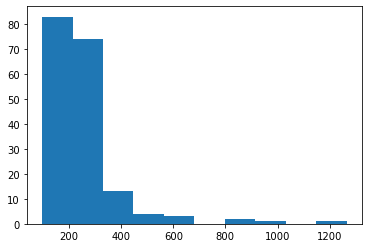

In [716]:
# checking for enough variation (fingers crossed)
plt.hist(msa_housing['MEDIAN_VAL']);

In [816]:
len(msa_housing)

182

This looks like something I *might* be able to work with. 

Now I need to match CBSA codes to FIPS codes to get the county-level data in there. 

In [717]:
# importing, cleaning up CBSA_FIPS
CBSA_FIPS = pd.read_csv('https://data.nber.org/cbsa-csa-fips-county-crosswalk/cbsa2fipsxw.csv')

CBSA_FIPS.drop(columns=['metrodivisioncode', 'cbsatitle','metropolitanmicropolitanstatis','metropolitandivisiontitle','csatitle', 'csacode'], inplace=True)

CBSA_FIPS.rename(columns={'cbsacode':'CBSA', 'countycountyequivalent':'COUNTY', 'statename':'STATE'},inplace=True)

# removing some regions we don't want
CBSA_FIPS = CBSA_FIPS[CBSA_FIPS['STATE'] != 'Puerto Rico']
CBSA_FIPS = CBSA_FIPS[CBSA_FIPS['STATE'] != 'District of Columbia']
CBSA_FIPS = CBSA_FIPS[CBSA_FIPS['STATE'] != 'Alaska']
CBSA_FIPS = CBSA_FIPS[CBSA_FIPS['STATE'] != 'Hawaii']

CBSA_FIPS.dropna()

#CBSA_FIPS.statename.value_counts()
#CBSA_FIPS.tail()

,CBSA,COUNTY,STATE,fipsstatecode,fipscountycode,centraloutlyingcounty
1,33860.0,Autauga County,Alabama,1.0,1.0,Central
2,19300.0,Baldwin County,Alabama,1.0,3.0,Central
3,13820.0,Bibb County,Alabama,1.0,7.0,Outlying
4,13820.0,Blount County,Alabama,1.0,9.0,Outlying
5,11500.0,Calhoun County,Alabama,1.0,15.0,Central
...,...,...,...,...,...,...
1804,16220.0,Natrona County,Wyoming,56.0,25.0,Central
1805,43260.0,Sheridan County,Wyoming,56.0,33.0,Central
1806,40540.0,Sweetwater County,Wyoming,56.0,37.0,Central
1807,27220.0,Teton County,Wyoming,56.0,39.0,Central


In [718]:
CBSA_FIPS = CBSA_FIPS[CBSA_FIPS['fipsstatecode'].notna()]

CBSA_FIPS = CBSA_FIPS[CBSA_FIPS['fipscountycode'].notna()]

CBSA_FIPS.tail()

,CBSA,COUNTY,STATE,fipsstatecode,fipscountycode,centraloutlyingcounty
1804,16220.0,Natrona County,Wyoming,56.0,25.0,Central
1805,43260.0,Sheridan County,Wyoming,56.0,33.0,Central
1806,40540.0,Sweetwater County,Wyoming,56.0,37.0,Central
1807,27220.0,Teton County,Wyoming,56.0,39.0,Central
1808,21740.0,Uinta County,Wyoming,56.0,41.0,Central


In [719]:
# creating combined FIPS column
CBSA_FIPS['fipsstatecode'] = CBSA_FIPS['fipsstatecode'].apply(lambda x: int(x))
CBSA_FIPS['fipscountycode'] = CBSA_FIPS['fipscountycode'].apply(lambda x: int(x))
CBSA_FIPS['CBSA'] = CBSA_FIPS['CBSA'].apply(lambda x: int(x))

CBSA_FIPS['FIPS'] = 1000*CBSA_FIPS['fipsstatecode'] + CBSA_FIPS['fipscountycode']

In [720]:
CBSA_FIPS.head()

,CBSA,COUNTY,STATE,fipsstatecode,fipscountycode,centraloutlyingcounty,FIPS
1,33860,Autauga County,Alabama,1,1,Central,1001
2,19300,Baldwin County,Alabama,1,3,Central,1003
3,13820,Bibb County,Alabama,1,7,Outlying,1007
4,13820,Blount County,Alabama,1,9,Outlying,1009
5,11500,Calhoun County,Alabama,1,15,Central,1015


# Pairing CBSA datapoints with the rest of the data

In [721]:
df = pd.merge(df, CBSA_FIPS[['FIPS','CBSA']], on='FIPS')
#df.head()

Now that I've paired the msa codes with the county codes, I need to get the housing costs into this combined dataset. 

In [722]:
df = pd.merge(df,msa_housing[['CBSA','MEDIAN_VAL']], on='CBSA')
#df.head()

# Linear Regression
Finally I have all the data I need to perform a liner regression. 

0. Data Preparation for Regression
1. EDA
2. Test-Validate Split
3. Train candidate models
    1. Ridge w various alphas
    2. LASSO w various alphas
4. Validate candidates, choose final model and alpha parameter
5. Train-Test Split using final model

## Data Preparation for Regression
I need to make sure that all my features are numerical, or at least ordinal. All are numerical except FIPS, CENSUS_DIV, TOPO, and RUCC_2013. Out of those, all are ordinal categories except CENSUS_DIV. 
I need to create dummy variables for the categorical feature, CENSUS_DIV. They're integers, but I still need to bust them into their own columns. I'm not sure how to approach this exact situation, so I'm actually going to make them string categories, and then use the process that I'm more familiar with for dealing with categories like that. 

In [723]:
# converting CENSUS_DIV to str, adding 'region' preceding value
df['CENSUS_DIV'] = df['CENSUS_DIV'].apply(lambda x: 'region '+str(x))

In [724]:
cat_x = df.loc[:, ['CENSUS_DIV']]
cat_y = df['MEDIAN_VAL']
#cat_x.value_counts()

The dataset is divided into 9 census regions that are encapsulated in CENSUS_DIV. So I should be able to create 8 new features to encapsulate this. 

In [725]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(cat_x)

OneHotEncoder(drop='first', sparse=False)

In [726]:
# transforming ohe_x, putting cat feature into a df
ohe_x = ohe.transform(cat_x)
columns = ohe.get_feature_names(['CENSUS_DIV'])
ohe_x_df = pd.DataFrame(ohe_x, columns=columns, index=cat_x.index)
# ohe_x_df

In [727]:
# recombining the categorical and numeric variables
df = pd.concat([df, ohe_x_df],axis=1)
df.columns

Index(['FIPS', 'STATE', 'COUNTY', 'CENSUS_DIV', 'JAN_TEMP', 'JAN_SUN',
       'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK', 'RUCC_2013', 'DENSITY',
       'CBSA', 'MEDIAN_VAL', 'CENSUS_DIV_region 2', 'CENSUS_DIV_region 3',
       'CENSUS_DIV_region 4', 'CENSUS_DIV_region 5', 'CENSUS_DIV_region 6',
       'CENSUS_DIV_region 7', 'CENSUS_DIV_region 8', 'CENSUS_DIV_region 9'],
      dtype='object')

## Exploratory Data Analysis

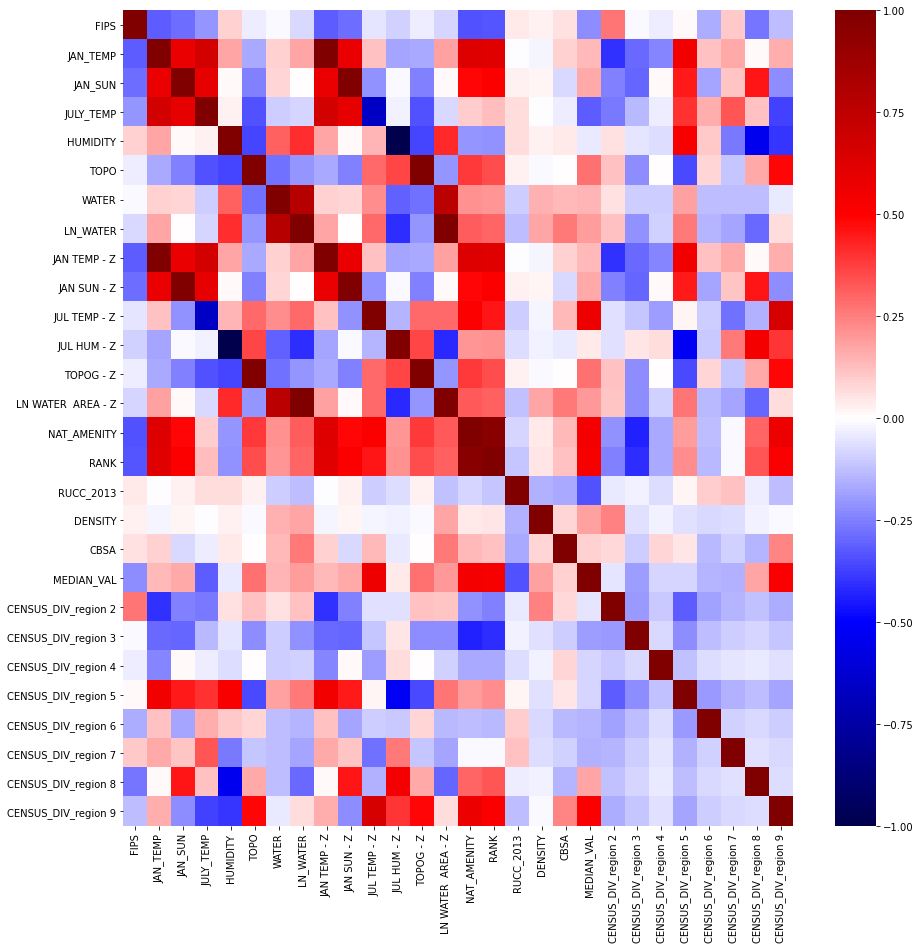

In [728]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

From a first glance, it seems that the things that correlate the most strongly with MEDIAN_VAL are being in census region 9, the z-score for July temperature, and the natural amenity score, which is interesting... I expected the RUCC_2013 scores to be more correlated, but the relationship isn't that strong.

In [729]:
#sns.pairplot(df)

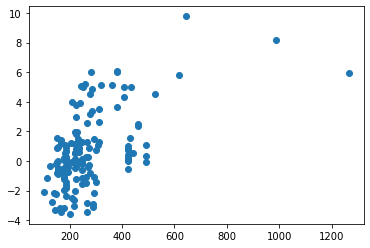

In [730]:
plt.scatter(df['MEDIAN_VAL'], df['NAT_AMENITY'])

## Test-validate-train split

In [428]:
# importing tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# separating target (y) from features (x)
x, y = num_df.drop('MEDIAN_VAL',axis=1), df['MEDIAN_VAL']

x, x_test, y, y_test = train_test_split(x, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = .25, random_state = 6)

#this helps with the way kf will generate indices below
x, y = np.array(x), np.array(y)

## Standard-Scaling my Variables

In [429]:
# importing tools
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

## Using Cross-Validation to determine alpha and model type

In [485]:
from sklearn.model_selection import KFold


x, y = num_df.drop('MEDIAN_VAL',axis=1), df['MEDIAN_VAL']
x, x_test, y, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

x,y = np.array(x), np.array(y)

In [877]:
def regression():
    '''
    regression(columns)
    This function takes the columns that we want to create a regression of housing price based on, and
    returns a plot of the mean absolute error for various regularization strengths, for both a LASSO 
    and Ridge regression.
    '''
    # split the data
    x, y = num_df.drop('MEDIAN_VAL',axis=1), df['MEDIAN_VAL']
    x, x_test, y, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

    x,y = np.array(x), np.array(y)
    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 51)

    # create array of regularization strengths
    alphalist = 10**np.linspace(0,4,100)

    # creating 
    ridge_val_err = np.zeros(len(alphalist))
    lasso_val_err = np.zeros(len(alphalist))   

    ridge_err_list = []
    lasso_err_list = []

    # looping through alpha values
    for i,a in enumerate(alphalist):

        ridge = Ridge(alpha=a)
        lasso = Lasso(alpha=a)

        ridge_err = []
        lasso_err = []

        # looping through k-folds
        for train_index, val_index in kf.split(x,y):

            # creating train / validation split
            x_train, y_train = x[train_index], y[train_index]
            x_val, y_val = x[val_index], y[val_index]  

            #scaling features
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)

            # training models
            ridge.fit(x_train,y_train)
            lasso.fit(x_train, y_train)

            # making predictions
            ridge_pred = ridge.predict(x_val)
            lasso_pred = lasso.predict(x_val)

            # collecting results for the fold
            ridge_err.append(r2_score(y_val, ridge_pred))
            lasso_err.append(r2_score(y_val, lasso_pred))

        # averaging errors in each fold

        ridge_mean_err = np.mean(ridge_err)
        lasso_mean_err = np.mean(lasso_err)

        ridge_err_list.append(ridge_mean_err)
        lasso_err_list.append(lasso_mean_err)

    plt.plot(np.log10(alphalist), ridge_err_list, label = 'Ridge');
    plt.plot(np.log10(alphalist), lasso_err_list, label = 'LASSO');
    plt.title('r2 based on regularizations strength');
    plt.legend();
    plt.xlabel('Regularization strength (log scale)');
    plt.ylabel('r2');

    print('\n The r2 for ridge was', np.max(ridge_err_list))
    print('The r2 for LASSO was', np.max(lasso_err_list))
    
    plt.savefig('initial_reg_curve.png')


 The r2 for ridge was 0.28343940586807503
The r2 for LASSO was 0.1973595569483082


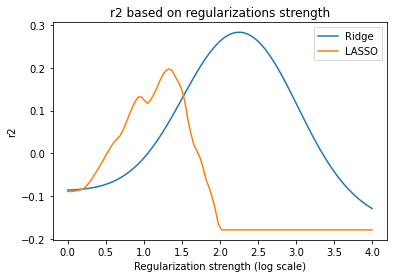

In [878]:
regression()

# Using Scikit-Learn shortcuts

In [ ]:
# imports
from sklearn.linear_model import LassoCV, RidgeCV

### 1. Env factors only

In [897]:
# splitting data
x = df[['JAN_TEMP','JAN_SUN','JULY_TEMP','HUMIDITY','TOPO','WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK']]

y = df['MEDIAN_VAL']

x, x_test, y, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

x,y = np.array(x), np.array(y)

#scaling data
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

alphavec = np.linspace(2,50,100) # I ran this test a few times to find the best range for alphas

# performing regression
lasso = LassoCV(alphas = alphavec, cv= 5)
ridge = RidgeCV(alphas = alphavec, cv= 5)

lasso.fit(x,y)
ridge.fit(x,y)

lasso_pred = lasso.predict(x)
ridge_pred = ridge.predict(x)

print('Best LASSO alpha:     ', round(lasso.alpha_, 2))
print('Best RIDGE alpha:     ', round(ridge.alpha_, 2))
print('')
print('Testing LASSO r2:     ', round(r2_score(y, lasso_pred),2))
print('Testing Ridge r2:     ', round(r2_score(y, ridge_pred),2))

print('Ridge train MAE', mae(y, ridge_pred))

Best LASSO alpha:      4.42
Best RIDGE alpha:      42.73

Testing LASSO r2:      0.49
Testing Ridge r2:      0.47
Ridge train MAE 71.9054400778275


### 2. Urbanization / regional factors only

In [882]:
# splitting data
x = df[['RUCC_2013','DENSITY','CENSUS_DIV_region 2', 'CENSUS_DIV_region 3',
       'CENSUS_DIV_region 4', 'CENSUS_DIV_region 5', 'CENSUS_DIV_region 6',
       'CENSUS_DIV_region 7', 'CENSUS_DIV_region 8', 'CENSUS_DIV_region 9']]

y = df['MEDIAN_VAL']

x, x_test, y, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

x,y = np.array(x), np.array(y)

#scaling data
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

alphavec = np.linspace(2,100,100) # I ran this test a few times to find the best range for alphas

# performing regression
lasso = LassoCV(alphas = alphavec, cv= 5)
ridge = RidgeCV(alphas = alphavec, cv= 5)

lasso.fit(x,y)
ridge.fit(x,y)

lasso_pred = lasso.predict(x)
ridge_pred = ridge.predict(x)

print('Best LASSO alpha:     ', round(lasso.alpha_, 2))
print('Best RIDGE alpha:     ', round(ridge.alpha_, 2))
print('')
print('Val LASSO r2:         ', round(r2_score(y, lasso_pred),2))
print('Val Ridge r2:         ', round(r2_score(y, ridge_pred),2))
print(mae(y, ridge_pred))

Best LASSO alpha:      9.92
Best RIDGE alpha:      57.43

Val LASSO r2:          0.44
Val Ridge r2:          0.43
62.918671237736525


### 3. All factors combined

In [900]:
# splitting data
x = df[['JAN_TEMP', 'JAN_SUN',
       'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK', 'RUCC_2013', 'DENSITY',
       'CBSA', 'CENSUS_DIV_region 2', 'CENSUS_DIV_region 3',
       'CENSUS_DIV_region 4', 'CENSUS_DIV_region 5', 'CENSUS_DIV_region 6',
       'CENSUS_DIV_region 7', 'CENSUS_DIV_region 8', 'CENSUS_DIV_region 9']]

y = df['MEDIAN_VAL']

x_tr, x_test, y_tr, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

#x_tr,y_tr = np.array(x_tr), np.array(y_tr)

#scaling data
scaler = StandardScaler()
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_test = scaler.transform(x_test)

from sklearn.linear_model import LassoCV, RidgeCV

alphavec = np.linspace(0.4,4,100) # I ran this test a few times to find the best range for alphas

lasso = LassoCV(alphas = alphavec, cv= 5)
ridge = RidgeCV(alphas = alphavec, cv= 5)

lasso.fit(x_tr,y_tr)
ridge.fit(x_tr,y_tr)

lasso_tr_pred = lasso.predict(x_tr)
lasso_test_pred = lasso.predict(x_test)

ridge_tr_pred = ridge.predict(x_tr)
ridge_test_pred = ridge.predict(x_test)

print('Best LASSO alpha:     ', round(lasso.alpha_, 2))
print('Best RIDGE alpha:     ', round(ridge.alpha_, 2))
print('')
print('Training LASSO r2:    ', round(r2_score(y_tr, lasso_tr_pred),2))
print('Testing LASSO r2:     ', round(r2_score(y_test, lasso_test_pred),2))
print('Testing LASSO MAE:    ', round(mae(y_test, lasso_test_pred),2))
print('')
print('Training Ridge r2:    ', round(r2_score(y_tr, ridge_tr_pred),2))
print('Testing Ridge r2:     ', round(r2_score(y_test, ridge_test_pred),2))
print('Training Ridge MAE:   ', round(mae(y_tr, ridge_tr_pred),2))

Best LASSO alpha:      4.0
Best RIDGE alpha:      4.0

Training LASSO r2:     0.71
Testing LASSO r2:      0.3
Testing LASSO MAE:     70.63

Training Ridge r2:     0.74
Testing Ridge r2:      0.3
Training Ridge MAE:    52.31


In [901]:
cols = ['JAN_TEMP', 'JAN_SUN',
       'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK', 'RUCC_2013', 'DENSITY',
       'CBSA', 'CENSUS_DIV_region 2', 'CENSUS_DIV_region 3',
       'CENSUS_DIV_region 4', 'CENSUS_DIV_region 5', 'CENSUS_DIV_region 6',
       'CENSUS_DIV_region 7', 'CENSUS_DIV_region 8', 'CENSUS_DIV_region 9']

coef = list(zip(cols,ridge.coef_))
#print(coef)

for i in range(len(coef)):
    print( coef[i])
    print('\n')

('JAN_TEMP', -14.826413020486642)


('JAN_SUN', 28.99255756448606)


('JULY_TEMP', -20.566754944163176)


('HUMIDITY', 44.8988957394561)


('TOPO', -2.532931287020849)


('WATER', -14.766650608991291)


('LN_WATER', 0.3261113093513835)


('JAN TEMP - Z', -14.824890514342494)


('JAN SUN - Z', 28.9921855264864)


('JUL TEMP - Z', 11.676492461162779)


('JUL HUM - Z', -44.897101326841835)


('TOPOG - Z', -2.5324000022246187)


('LN WATER  AREA - Z', 7.102584784036096)


('NAT_AMENITY', -2.6239198615244144)


('RANK', 19.81545101641325)


('RUCC_2013', -35.27003657778466)


('DENSITY', 22.853922402280304)


('CBSA', -8.605360339726666)


('CENSUS_DIV_region 2', -12.089951681119105)


('CENSUS_DIV_region 3', -2.854725105937922)


('CENSUS_DIV_region 4', -8.28271433626549)


('CENSUS_DIV_region 5', -40.428570561811746)


('CENSUS_DIV_region 6', 0.040354138195163244)


('CENSUS_DIV_region 7', 16.1381958468796)


('CENSUS_DIV_region 8', 49.48327734796051)


('CENSUS_DIV_region 9', 97.04793397

In [894]:
x_tr.shape

(152, 26)

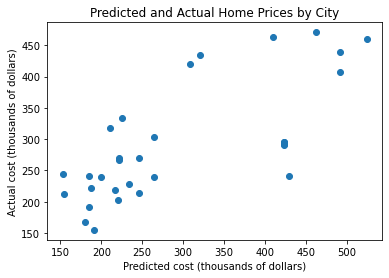

In [867]:
plt.scatter(y_test, ridge_test_pred)
plt.title('Predicted and Actual Home Prices by City');
plt.xlabel('Predicted cost (thousands of dollars)');
plt.ylabel('Actual cost (thousands of dollars)');
#plt.savefig('predicted_actual_test.png')

In [861]:
ridge_test_pred

AttributeError: 'numpy.ndarray' object has no attribute 'index'

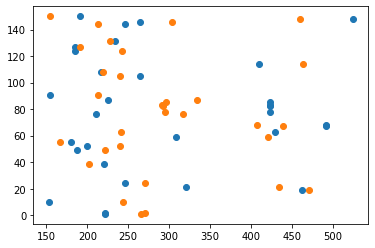

In [862]:
plt.scatter(y_test.values, y_test.index)
plt.scatter(ridge_test_pred, y_test.index)

### Diagnostics for model 3 (ridge, all features)

In [822]:
alphavec = np.linspace(0.1,3,100)
ridge = RidgeCV(alphas = alphavec, cv=5)
ridge.fit(x_tr, y_tr)
ridge.score(x_tr,y_tr)

0.7067050139399098

In [823]:
diag_df = pd.DataFrame()
diag_df['ACTUAL'] = y_tr
diag_df['PRED'] = ridge.predict(x_tr)
diag_df['RESID'] = diag_df['ACTUAL'] - diag_df['PRED']

<AxesSubplot:xlabel='PRED', ylabel='ACTUAL'>

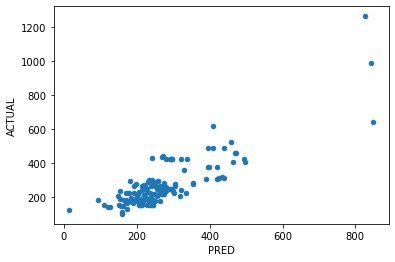

In [824]:
diag_df.plot(kind='scatter',
            x='PRED',y='ACTUAL')


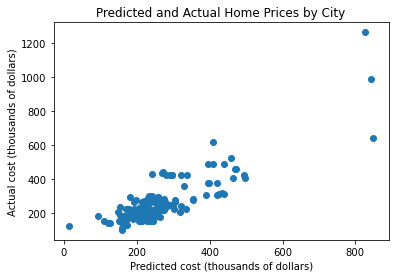

In [828]:
plt.scatter(diag_df.PRED, diag_df.ACTUAL)
plt.title('Predicted and Actual Home Prices by City');
plt.xlabel('Predicted cost (thousands of dollars)');
plt.ylabel('Actual cost (thousands of dollars)');
plt.savefig('predicted_actual.png')

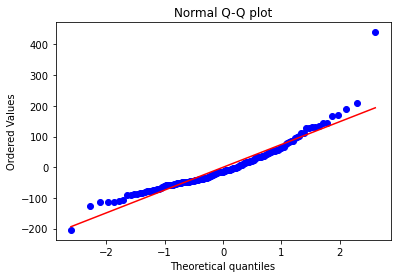

In [829]:
import scipy.stats as stats
stats.probplot(diag_df['RESID'], dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

There seem to be a few outliers at the high end of the range that are throwing the model off. Let's investigate them.

In [734]:
# dropping outliers
df[df.MEDIAN_VAL > 600]

,FIPS,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,TOPO,WATER,...,CBSA,MEDIAN_VAL,CENSUS_DIV_region 2,CENSUS_DIV_region 3,CENSUS_DIV_region 4,CENSUS_DIV_region 5,CENSUS_DIV_region 6,CENSUS_DIV_region 7,CENSUS_DIV_region 8,CENSUS_DIV_region 9
15,6073,CA,SAN DIEGO,region 9,55.2,224,69.6,68,21,7.10,...,41740,645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16,6081,CA,SAN MATEO,region 9,49.5,171,65.0,74,16,39.40,...,41860,988.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,6085,CA,SANTA CLARA,region 9,49.5,171,68.4,74,20,1.02,...,41940,1265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,8013,CO,BOULDER,region 8,33.0,214,73.9,36,21,1.19,...,14500,618.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Dropping outliers
We want to drop SANTA CLARA, SAN MATEO, and SAN DIEGO. They are the three outliers that are a lot more expensive than our model thinks they should be.

In [830]:
dropout = df
#dropout = dropout.drop(dropout[dropout['COUNTY'] == 'SANTA CLARA'], axis=0)

In [831]:
dropout = dropout.drop(index=[15,16,17])
#dropout.head(20)

# Testing on data without outliers

In [832]:
# training ridge on dropout
# splitting data
x = dropout[['JAN_TEMP', 'JAN_SUN',
       'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK', 'RUCC_2013', 'DENSITY',
       'CBSA', 'CENSUS_DIV_region 2', 'CENSUS_DIV_region 3',
       'CENSUS_DIV_region 4', 'CENSUS_DIV_region 5', 'CENSUS_DIV_region 6',
       'CENSUS_DIV_region 7', 'CENSUS_DIV_region 8', 'CENSUS_DIV_region 9']]

y = dropout['MEDIAN_VAL']

x_tr, x_test, y_tr, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

x_tr,y_tr = np.array(x), np.array(y)

#scaling data
scaler = StandardScaler()
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_test = scaler.transform(x_test)

alphavec = np.linspace(0.4,4,100) # I ran this test a few times to find the best range for alphas

lasso = LassoCV(alphas = alphavec, cv= 5)
ridge = RidgeCV(alphas = alphavec, cv= 5)

lasso.fit(x_tr,y_tr)
ridge.fit(x_tr,y_tr)

lasso_tr_pred = lasso.predict(x_tr)
lasso_test_pred = lasso.predict(x_test)

ridge_tr_pred = ridge.predict(x_tr)
ridge_test_pred = ridge.predict(x_test)

print('Best LASSO alpha:', round(lasso.alpha_, 2))
print('Best RIDGE alpha:', round(ridge.alpha_, 2))
print('')
print('Training LASSO r2:', round(r2_score(y_tr, lasso_tr_pred),2))
print('Testing LASSO r2:', round(r2_score(y_test, lasso_test_pred),2))
print('Testing LASSO MAE:', round(mae(y_test, lasso_test_pred),2))
print('')
print('Training Ridge r2:', round(r2_score(y_tr, ridge_tr_pred),2))
print('Testing Ridge r2:', round(r2_score(y_test, ridge_test_pred),2))
print('Testing Ridge MAE:', round(mae(y_test, ridge_test_pred),2))

Best LASSO alpha: 2.51
Best RIDGE alpha: 4.0

Training LASSO r2: 0.54
Testing LASSO r2: 0.57
Testing LASSO MAE: 46.75

Training Ridge r2: 0.59
Testing Ridge r2: 0.55
Testing Ridge MAE: 48.48


By removing the three outlier cities, we have increased the Ridge r2 from 0.52 to 0.55, and reduced MAE from 64,230 to 48,480. Interestingly, the LASSO regression now outperforms the Ridge slightly. It's r2 is now 0.57, with a MAE of 46,750...

# Diagnostics on new data

<AxesSubplot:xlabel='PRED', ylabel='ACTUAL'>

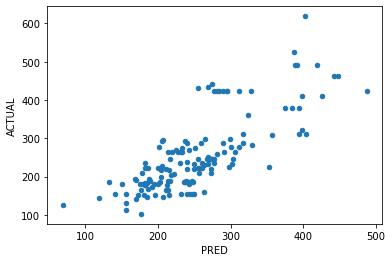

In [833]:
diag_df = pd.DataFrame()
diag_df['ACTUAL'] = y_tr
diag_df['PRED'] = ridge.predict(x_tr)
diag_df['RESID'] = diag_df['ACTUAL'] - diag_df['PRED']

diag_df.plot(kind='scatter',
            x='PRED',y='ACTUAL')

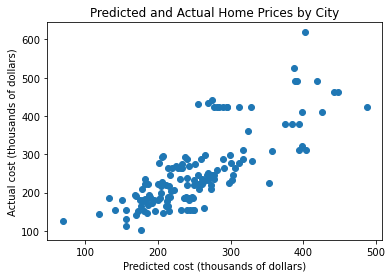

In [836]:
plt.scatter(diag_df['PRED'], diag_df['ACTUAL'])
plt.title('Predicted and Actual Home Prices by City')
plt.xlabel('Predicted cost (thousands of dollars)')
plt.ylabel('Actual cost (thousands of dollars)')
plt.savefig('predicted_actual_no_outliers_added_exp.png')

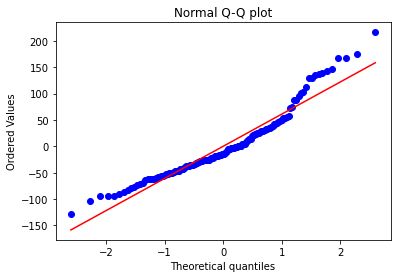

In [792]:
stats.probplot(diag_df['RESID'], dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

Hmm, there is still a curve to the Q-Q plot. Maybe I need to add an interaction feature somewhere. The highly rated cities are more valuable than they should be still. 

# Adding exponential feature
I want to capture the pattern that cities that are predicted to be expensive tend to be even more expensive than the model would predict. 

In [804]:
df.head()

,FIPS,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,TOPO,WATER,...,CBSA,MEDIAN_VAL,CENSUS_DIV_region 2,CENSUS_DIV_region 3,CENSUS_DIV_region 4,CENSUS_DIV_region 5,CENSUS_DIV_region 6,CENSUS_DIV_region 7,CENSUS_DIV_region 8,CENSUS_DIV_region 9
0,1073,AL,JEFFERSON,region 6,44.2,130,79.9,66,15,1.00,...,13820,221.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1117,AL,SHELBY,region 6,45.0,130,79.3,66,15,1.81,...,13820,221.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1127,AL,WALKER,region 6,43.7,130,79.6,66,14,1.35,...,13820,221.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1083,AL,LIMESTONE,region 6,41.2,130,79.2,65,4,6.43,...,26620,223.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1089,AL,MADISON,region 6,40.9,130,79.5,65,6,0.98,...,26620,223.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [837]:
dropout['NAT2'] = dropout['NAT_AMENITY']**2

In [812]:
dropout.head()

,FIPS,STATE,COUNTY,CENSUS_DIV,JAN_TEMP,JAN_SUN,JULY_TEMP,HUMIDITY,TOPO,WATER,...,MEDIAN_VAL,CENSUS_DIV_region 2,CENSUS_DIV_region 3,CENSUS_DIV_region 4,CENSUS_DIV_region 5,CENSUS_DIV_region 6,CENSUS_DIV_region 7,CENSUS_DIV_region 8,CENSUS_DIV_region 9,NAT2
0,1073,AL,JEFFERSON,region 6,44.2,130,79.9,66,15,1.00,...,221.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2601
1,1117,AL,SHELBY,region 6,45.0,130,79.3,66,15,1.81,...,221.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.2544
2,1127,AL,WALKER,region 6,43.7,130,79.6,66,14,1.35,...,221.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2601
3,1083,AL,LIMESTONE,region 6,41.2,130,79.2,65,4,6.43,...,223.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.1764
4,1089,AL,MADISON,region 6,40.9,130,79.5,65,6,0.98,...,223.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.5625


# Performing eda with exponential feature

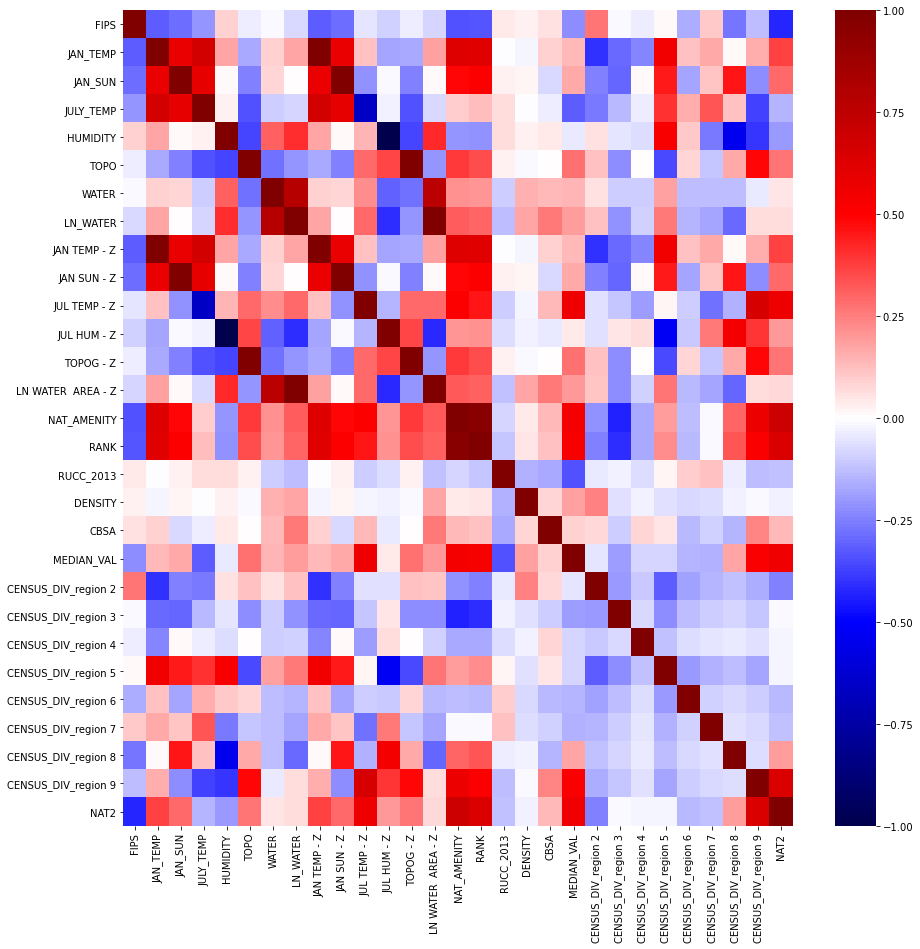

In [810]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [929]:
# adding boxcox transformation
dropout['TRANSFORMED_VAL'] = 1/np.sqrt(dropout['MEDIAN_VAL'])

# Modeling with exponential feature

# ALL FEATURES

In [931]:
# training ridge on dropout
# splitting data
x = dropout[['JAN_TEMP', 'JAN_SUN',
       'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK', 'RUCC_2013', 'DENSITY',
       'CBSA', 'CENSUS_DIV_region 2', 'CENSUS_DIV_region 3',
       'CENSUS_DIV_region 4', 'CENSUS_DIV_region 5', 'CENSUS_DIV_region 6',
       'CENSUS_DIV_region 7', 'CENSUS_DIV_region 8', 'CENSUS_DIV_region 9','NAT2']]

y = dropout['TRANSFORMED_VAL']

x_tr, x_test, y_tr, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

x_tr,y_tr = np.array(x), np.array(y)

#scaling data
scaler = StandardScaler()
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_test = scaler.transform(x_test)

alphavec = 10**np.linspace(-2,2,200) # I ran this test a few times to find the best range for alphas

lasso = LassoCV(alphas = alphavec, cv= 5)
ridge = RidgeCV(alphas = alphavec, cv= 5)

lasso.fit(x_tr,y_tr)
ridge.fit(x_tr,y_tr)

lasso_tr_pred = lasso.predict(x_tr)
lasso_test_pred = lasso.predict(x_test)

ridge_tr_pred = ridge.predict(x_tr)
ridge_test_pred = ridge.predict(x_test)

#print('Best LASSO alpha:', round(lasso.alpha_, 2))
print('Best RIDGE alpha:', round(ridge.alpha_, 2))
#print('')
#print('Training LASSO r2:', round(r2_score(y_tr, lasso_tr_pred),2))
#print('Testing LASSO r2:', round(r2_score(y_test, lasso_test_pred),2))
#print('Testing LASSO MAE:', round(mae(y_test, lasso_test_pred),2))
#print('')
print('Training Ridge r2:', round(r2_score(y_tr, ridge_tr_pred),2))
print('Testing Ridge r2:', round(r2_score(y_test, ridge_test_pred),2))
print('Training Ridge MAE:', round(mae(y_tr, ridge_tr_pred),2))
print('Testing Ridge MAE:', round(mae(y_test, ridge_test_pred),2))

Best RIDGE alpha: 34.49
Training Ridge r2: 0.57
Testing Ridge r2: 0.57
Training Ridge MAE: 0.01
Testing Ridge MAE: 0.01


# NATURAL ONLY

In [928]:
# training ridge on dropout
# splitting data
x = dropout[['JAN_TEMP', 'JAN_SUN',
       'JULY_TEMP', 'HUMIDITY', 'TOPO', 'WATER', 'LN_WATER', 'JAN TEMP - Z',
       'JAN SUN - Z', 'JUL TEMP - Z', 'JUL HUM - Z', 'TOPOG - Z',
       'LN WATER  AREA - Z', 'NAT_AMENITY', 'RANK', 'NAT2']]

y = dropout['TRANSFORMED_VAL']

x_tr, x_test, y_tr, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

#scaling data
scaler = StandardScaler()
scaler.fit(x_tr.values)
x_tr = scaler.transform(x_tr.values)
x_test = scaler.transform(x_test.values)

alphavec = 10**np.linspace(-4,4,100) # I ran this test a few times to find the best range for alphas

lasso = LassoCV(alphas = alphavec, cv= 5)
ridge = RidgeCV(alphas = alphavec, cv= 5)

lasso.fit(x_tr,y_tr)
ridge.fit(x_tr,y_tr)

lasso_tr_pred = lasso.predict(x_tr)
lasso_test_pred = lasso.predict(x_test)

ridge_tr_pred = ridge.predict(x_tr)
ridge_test_pred = ridge.predict(x_test)

#print('Best LASSO alpha:', round(lasso.alpha_, 2))
print('Best RIDGE alpha:', ridge.alpha_)
#print('')
#print('Training LASSO r2:', round(r2_score(y_tr, lasso_tr_pred),2))
#print('Testing LASSO r2:', round(r2_score(y_test, lasso_test_pred),2))
#print('Testing LASSO MAE:', round(mae(y_test, lasso_test_pred),2))
#print('')
print('Training Ridge r2:', round(r2_score(y_tr, ridge_tr_pred),2))
print('Testing Ridge r2:', round(r2_score(y_test, ridge_test_pred),2))
print('Training Ridge MAE:', round(mae(y_tr, ridge_tr_pred),2))
print('Testing Ridge MAE:', round(mae(y_test, ridge_test_pred),2))

Best RIDGE alpha: 0.0001747528400007683
Training Ridge r2: 0.43
Testing Ridge r2: 0.14
Training Ridge MAE: 0.01
Testing Ridge MAE: 0.01


# Diagnostics on data without outliers, and with exponential term

<AxesSubplot:xlabel='PRED', ylabel='ACTUAL'>

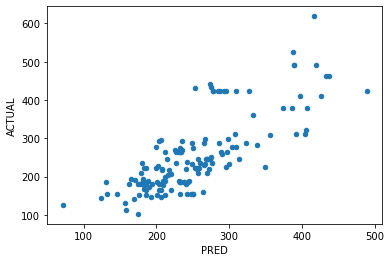

In [839]:
diag_df = pd.DataFrame()
diag_df['ACTUAL'] = y_tr
diag_df['PRED'] = ridge.predict(x_tr)
diag_df['RESID'] = diag_df['ACTUAL'] - diag_df['PRED']

diag_df.plot(kind='scatter',
            x='PRED',y='ACTUAL')

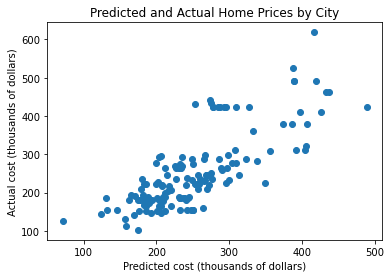

In [840]:
plt.scatter(diag_df['PRED'], diag_df['ACTUAL'])
plt.title('Predicted and Actual Home Prices by City')
plt.xlabel('Predicted cost (thousands of dollars)')
plt.ylabel('Actual cost (thousands of dollars)')
plt.savefig('predicted_actual_no_outliers_added_exp.png')

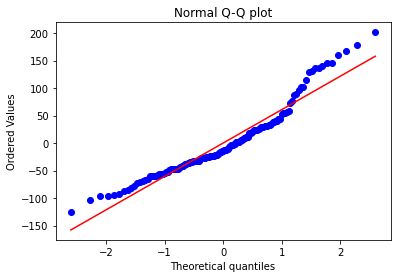

In [815]:
stats.probplot(diag_df['RESID'], dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

# Pickling final dataset

In [845]:
import pickle

dropout.to_pickle('/Users/patricknorman/Documents/GitHub/metis-project-2/data/dropout.pkl')

In [865]:
dropout.shape

(149, 32)

# Applying BoxCox

In [905]:
import scipy.stats as stats
stats.boxcox(dropout['MEDIAN_VAL'])

(array([1.88174388, 1.88174388, 1.88174388, 1.88233285, 1.88233285,
        1.85342037, 1.89854713, 1.89854713, 1.85336586, 1.85336586,
        1.85336586, 1.91446822, 1.91446822, 1.91446822, 1.89736503,
        1.92433949, 1.92433949, 1.93739363, 1.90506164, 1.8888353 ,
        1.8888353 , 1.8888353 , 1.8888353 , 1.8888353 , 1.8888353 ,
        1.8888353 , 1.88684526, 1.92139101, 1.89204588, 1.89612544,
        1.89612544, 1.91156701, 1.88851426, 1.87797696, 1.88300555,
        1.88983666, 1.88121046, 1.88339846, 1.88522708, 1.88522708,
        1.88522708, 1.85455292, 1.84811011, 1.8936014 , 1.8936014 ,
        1.8697012 , 1.8697012 , 1.8697012 , 1.8697012 , 1.87450724,
        1.87174152, 1.86008222, 1.8666047 , 1.8666047 , 1.8666047 ,
        1.86933947, 1.90284278, 1.90107227, 1.90107227, 1.92205593,
        1.92081687, 1.88224036, 1.88399642, 1.92729712, 1.92729712,
        1.92729712, 1.84726598, 1.8781457 , 1.90012599, 1.89886367,
        1.89886367, 1.86630586, 1.85449951, 1.87